# Importando módulos 

In [176]:
import obspy
from obspy.taup import TauPyModel

from multiprocessing import Pool
from obspy import read,UTCDateTime,Trace
from obspy.clients.fdsn import Client
import os
import glob
import numpy as np
from collections import defaultdict
import pandas as pd

#para plotar as figuras
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator, DayLocator, HourLocator, MinuteLocator, SecondLocator, DateFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from datetime import datetime,timedelta,date
from tqdm import tqdm

from shapely.geometry.polygon import LinearRing

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from IPython.display import HTML
from IPython import display

# Inputs e Outputs

In [177]:
FOLDER_OUTPUT = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/'

MSEED_INPUT = "/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/MSEED/"

METADATA_OUTPUT = "/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/OUTPUT/METADATA/"

filename_csv = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/metadados_glider_acustico_pmpas-bs.csv'

campanha_csv = '/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/Dados_campanhas_Gliders.xls'

# Extraindo informações dos arquivos ".mseed"

In [10]:
filenames_MSEED = sorted(glob.glob(MSEED_INPUT+'*/*/*.mseed'))

In [11]:
def mseed_data_2_dataframe(i):
    subdir, filename_wav = os.path.split(i)
    filename = filename_wav.split('.mseed')[0]
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]
        stream_number = filename.split('_')[1]

        year_month_day = filename.split('_')[2]
        hour_minute_second = filename.split('_')[3]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())


    if 'pa' in filename.split('_')[2]:

        mergulho = filename.split('_')[2].split('a')[1]
        stream_number = filename.split('_')[3]

        year_month_day = filename.split('_')[0]
        hour_minute_second = filename.split('_')[1]

        year = int('20'+year_month_day[:2])
        month = int(year_month_day[2:4])
        day = int(year_month_day[4:])

        hour = int(hour_minute_second[:2])
        minute = int(hour_minute_second[2:4])
        second = int(hour_minute_second[4:])

        d = UTCDateTime(datetime(year,month,day,hour,minute,second).isoformat())
        
    
    st = read(i,headonly=True)   
    #----------------------------
    #Starting Dataframe

    starttime = st[0].stats.starttime.datetime
    endtime = st[0].stats.endtime.datetime
    sampling_rate = st[0].stats.sampling_rate
    npts = st[0].stats.npts

    
    df = pd.DataFrame([[filename],[mergulho],[stream_number],[starttime],[endtime],[sampling_rate],[npts]], index=['filename_mseed', 'mergulho', 'stream_number','starttime','endtime','sampling_rate','npts']).T
    
    #Ending Dataframe
    #----------------------------
    return df

In [12]:
pandas_mseed_lst = []

with Pool(processes=4) as p:
    max_ = len(filenames_MSEED)
    with tqdm(total=max_) as pbar:
        for result in p.imap_unordered(mseed_data_2_dataframe,filenames_MSEED):
            pbar.update()
            pandas_mseed_lst.append(result)

100%|██████████████████████████████████| 124257/124257 [11:23<00:00, 181.70it/s]


In [178]:
dataframe_mseed_final = pd.concat(pandas_mseed_lst, ignore_index=True)

In [179]:
dataframe_mseed_final['starttime'] = pd.to_datetime(dataframe_mseed_final.starttime, format='%Y-%m-%d %H:%M:%S')
dataframe_mseed_final['endtime'] = pd.to_datetime(dataframe_mseed_final.endtime, format='%Y-%m-%d %H:%M:%S')


In [180]:
dataframe_mseed_final.sort_values(by='starttime')

filename_mseed mergulho stream_number           starttime  \
0       pa0001au_001_151112_134841     0001           001 2015-11-12 13:48:41   
3       pa0001au_002_151112_135041     0001           002 2015-11-12 13:50:41   
2       pa0001au_003_151112_135241     0001           003 2015-11-12 13:52:41   
1       pa0001au_004_151112_135441     0001           004 2015-11-12 13:54:41   
4       pa0001au_005_151112_135641     0001           005 2015-11-12 13:56:41   
...                            ...      ...           ...                 ...   
124251  pa0296au_008_211104_061338     0296           008 2021-11-04 06:13:38   
124252  pa0296au_009_211104_062338     0296           009 2021-11-04 06:23:38   
124253  pa0296au_010_211104_063338     0296           010 2021-11-04 06:33:38   
124255  pa0296au_011_211104_064338     0296           011 2021-11-04 06:43:38   
124254  pa0296au_012_211104_065338     0296           012 2021-11-04 06:53:38   

                       endtime sampling_rate   npts  
0      2015-11-12 13:50:40.930         100.0  11994  
3      2015-11-12 13:52:40.930         100.0  11994  
2      2015-11-12 13:54:40.930         100.0  11994  
1      2015-11-12 13:56:40.930         100.0  11994  
4      2015-11-12 13:57:00.980         100.0   1999  
...                        ...           ...    ...  
124251 2021-11-04 06:23:37.990         100.0  60000  
124252 2021-11-04 06:33:37.990         100.0  60000  
124253 2021-11-04 06:43:37.990         100.0  60000  
124255 2021-11-04 06:53:37.990         100.0  60000  
124254 2021-11-04 06:57:21.780         100.0  22379  

[124257 rows x 7 columns]

In [181]:
dataframe_mseed_final['date'] = dataframe_mseed_final['starttime'].dt.date

In [182]:
dataframe_mseed_final

filename_mseed mergulho stream_number           starttime  \
0       pa0001au_001_151112_134841     0001           001 2015-11-12 13:48:41   
1       pa0001au_004_151112_135441     0001           004 2015-11-12 13:54:41   
2       pa0001au_003_151112_135241     0001           003 2015-11-12 13:52:41   
3       pa0001au_002_151112_135041     0001           002 2015-11-12 13:50:41   
4       pa0001au_005_151112_135641     0001           005 2015-11-12 13:56:41   
...                            ...      ...           ...                 ...   
124252  pa0296au_009_211104_062338     0296           009 2021-11-04 06:23:38   
124253  pa0296au_010_211104_063338     0296           010 2021-11-04 06:33:38   
124254  pa0296au_012_211104_065338     0296           012 2021-11-04 06:53:38   
124255  pa0296au_011_211104_064338     0296           011 2021-11-04 06:43:38   
124256  pa0296au_005_211104_054338     0296           005 2021-11-04 05:43:38   

                       endtime sampling_rate   npts        date  
0      2015-11-12 13:50:40.930         100.0  11994  2015-11-12  
1      2015-11-12 13:56:40.930         100.0  11994  2015-11-12  
2      2015-11-12 13:54:40.930         100.0  11994  2015-11-12  
3      2015-11-12 13:52:40.930         100.0  11994  2015-11-12  
4      2015-11-12 13:57:00.980         100.0   1999  2015-11-12  
...                        ...           ...    ...         ...  
124252 2021-11-04 06:33:37.990         100.0  60000  2021-11-04  
124253 2021-11-04 06:43:37.990         100.0  60000  2021-11-04  
124254 2021-11-04 06:57:21.780         100.0  22379  2021-11-04  
124255 2021-11-04 06:53:37.990         100.0  60000  2021-11-04  
124256 2021-11-04 05:53:37.990         100.0  60000  2021-11-04  

[124257 rows x 8 columns]

# Extraindo informações do arquivo ".csv" com as campanhas

In [117]:
ciclos_dataframe_csv = pd.read_excel(campanha_csv)
ciclos_dataframe_csv

Sistema    Ciclo  starttime    endtime      Fs  nBits Hidrofone   PreAmp  \
0   GLIDER        1 2015-11-10 2015-12-20  125000     16    911006     1501   
1   GLIDER        2 2016-01-08 2016-02-02  125000     16    911006     1501   
2   GLIDER        3 2016-02-02 2016-04-20  125000     24    911008     1503   
3   GLIDER        4 2016-04-20 2016-07-07  125000     24    911006     1501   
4   GLIDER        5 2016-07-07 2016-08-16  125000     24    911008     1503   
..     ...      ...        ...        ...     ...    ...       ...      ...   
89  GLIDER  MC_C026 2023-06-22 2023-07-30  128000     24   G003654  AMAR-G4   
90  GLIDER  ME_C012 2023-06-20 2023-08-01  128000     24   C000811  AMAR-G4   
91  GLIDER  MC_C027 2023-12-30 2023-12-30  128000     24   G003654  AMAR-G4   
92  GLIDER  MC_C028 2023-08-03 2023-09-09  128000     24   F001108  AMAR-G4   
93  GLIDER  MC_C029 2023-09-24 2023-10-05  128000     24   I000091  AMAR-G4   

       N/S  
0    SG618  
1    SG618  
2    SG612  
3    SG612  
4    SG612  
..     ...  
89   SL976  
90   SL977  
91   SL975  
92   SL977  
93  SL1099  

[94 rows x 9 columns]

In [118]:
ciclos_dataframe_csv['starttime'] = pd.to_datetime(ciclos_dataframe_csv.starttime, format='%Y-%m-%d %H:%M:%S').dt.date
ciclos_dataframe_csv['endtime'] = pd.to_datetime(ciclos_dataframe_csv.endtime, format='%Y-%m-%d %H:%M:%S').dt.date

In [ ]:
ciclos_dataframe_csv['Ciclo_new'] = range(len(ciclos_dataframe_csv))

In [144]:
ciclos_dataframe_csv

Sistema    Ciclo   starttime     endtime      Fs  nBits Hidrofone   PreAmp  \
0   GLIDER        1  2015-11-10  2015-12-20  125000     16    911006     1501   
1   GLIDER        2  2016-01-08  2016-02-02  125000     16    911006     1501   
2   GLIDER        3  2016-02-02  2016-04-20  125000     24    911008     1503   
3   GLIDER        4  2016-04-20  2016-07-07  125000     24    911006     1501   
4   GLIDER        5  2016-07-07  2016-08-16  125000     24    911008     1503   
..     ...      ...         ...         ...     ...    ...       ...      ...   
89  GLIDER  MC_C026  2023-06-22  2023-07-30  128000     24   G003654  AMAR-G4   
90  GLIDER  ME_C012  2023-06-20  2023-08-01  128000     24   C000811  AMAR-G4   
91  GLIDER  MC_C027  2023-12-30  2023-12-30  128000     24   G003654  AMAR-G4   
92  GLIDER  MC_C028  2023-08-03  2023-09-09  128000     24   F001108  AMAR-G4   
93  GLIDER  MC_C029  2023-09-24  2023-10-05  128000     24   I000091  AMAR-G4   

       N/S  Ciclo_new  
0    SG618          0  
1    SG618          1  
2    SG612          2  
3    SG612          3  
4    SG612          4  
..     ...        ...  
89   SL976         89  
90   SL977         90  
91   SL975         91  
92   SL977         92  
93  SL1099         93  

[94 rows x 10 columns]

# Extraindo informações do arquivo ".csv" com as localizações (lat,lon,dep)

In [183]:
dataframe_csv = pd.read_csv(filename_csv,parse_dates=['time'])
dataframe_csv.sort_values(by='time')

time                                 filename  \
0      2015-11-12 13:48:40.999995  pa0001au_001_151112_134841_rms_spl3.mat   
1      2015-11-12 13:49:41.000001  pa0001au_001_151112_134841_rms_spl3.mat   
2      2015-11-12 13:50:40.999998  pa0001au_002_151112_135041_rms_spl3.mat   
3      2015-11-12 13:51:41.000004  pa0001au_002_151112_135041_rms_spl3.mat   
4      2015-11-12 13:52:41.000001  pa0001au_003_151112_135241_rms_spl3.mat   
...                           ...                                      ...   
547748 2021-11-04 06:52:38.000000  pa0296au_011_211104_064338_rms_spl3.mat   
547749 2021-11-04 06:53:37.999997  pa0296au_012_211104_065338_rms_spl3.mat   
547750 2021-11-04 06:54:38.000003  pa0296au_012_211104_065338_rms_spl3.mat   
547751 2021-11-04 06:55:38.000000  pa0296au_012_211104_065338_rms_spl3.mat   
547752 2021-11-04 06:56:37.999996  pa0296au_012_211104_065338_rms_spl3.mat   

         latitude  longitude       depth  
0      -23.825157 -42.495483    1.314286  
1      -23.824950 -42.495487    7.415555  
2      -23.824745 -42.495490   15.776000  
3      -23.824540 -42.495495   24.372000  
4      -23.824331 -42.495500   32.912000  
...           ...        ...         ...  
547748 -24.461742 -42.471264  866.012900  
547749 -24.461819 -42.471302  873.586100  
547750 -24.461980 -42.471510  879.579600  
547751 -24.462152 -42.471740  884.380700  
547752 -24.462324 -42.471966  888.467200  

[547753 rows x 5 columns]

In [184]:
df_csv = dataframe_csv.groupby("filename").agg(pd.Series.tolist)

In [185]:
df_csv['filename_mseed'] = df_csv.index.str.replace('_rms_spl3.mat', '')

In [186]:
df_csv.sort_values(by='time')

time  \
filename                                                                                     
pa0001au_001_151112_134841_rms_spl3.mat  [2015-11-12 13:48:40.999995, 2015-11-12 13:49:...   
pa0001au_002_151112_135041_rms_spl3.mat  [2015-11-12 13:50:40.999998, 2015-11-12 13:51:...   
pa0001au_003_151112_135241_rms_spl3.mat  [2015-11-12 13:52:41.000001, 2015-11-12 13:53:...   
pa0001au_004_151112_135441_rms_spl3.mat  [2015-11-12 13:54:41.000004, 2015-11-12 13:55:41]   
pa0002au_001_151112_143618_rms_spl3.mat  [2015-11-12 14:36:17.999998, 2015-11-12 14:37:...   
...                                                                                    ...   
pa0296au_008_211104_061338_rms_spl3.mat  [2021-11-04 06:13:37.999999, 2021-11-04 06:14:...   
pa0296au_009_211104_062338_rms_spl3.mat  [2021-11-04 06:23:38.000003, 2021-11-04 06:24:...   
pa0296au_010_211104_063338_rms_spl3.mat  [2021-11-04 06:33:37.999998, 2021-11-04 06:34:...   
pa0296au_011_211104_064338_rms_spl3.mat  [2021-11-04 06:43:38.000002, 2021-11-04 06:44:...   
pa0296au_012_211104_065338_rms_spl3.mat  [2021-11-04 06:53:37.999997, 2021-11-04 06:54:...   

                                                                                  latitude  \
filename                                                                                     
pa0001au_001_151112_134841_rms_spl3.mat                            [-23.825157, -23.82495]   
pa0001au_002_151112_135041_rms_spl3.mat                            [-23.824745, -23.82454]   
pa0001au_003_151112_135241_rms_spl3.mat                           [-23.824331, -23.824125]   
pa0001au_004_151112_135441_rms_spl3.mat                            [-23.82392, -23.823713]   
pa0002au_001_151112_143618_rms_spl3.mat                            [-23.817575, -23.81744]   
...                                                                                    ...   
pa0296au_008_211104_061338_rms_spl3.mat  [-24.457632, -24.457657, -24.457726, -24.45786...   
pa0296au_009_211104_062338_rms_spl3.mat  [-24.458628, -24.458672, -24.45872, -24.458822...   
pa0296au_010_211104_063338_rms_spl3.mat  [-24.459415, -24.459513, -24.45957, -24.45963,...   
pa0296au_011_211104_064338_rms_spl3.mat  [-24.46027, -24.460333, -24.460466, -24.460562...   
pa0296au_012_211104_065338_rms_spl3.mat    [-24.461819, -24.46198, -24.462152, -24.462324]   

                                                                                 longitude  \
filename                                                                                     
pa0001au_001_151112_134841_rms_spl3.mat                           [-42.495483, -42.495487]   
pa0001au_002_151112_135041_rms_spl3.mat                            [-42.49549, -42.495495]   
pa0001au_003_151112_135241_rms_spl3.mat                             [-42.4955, -42.495502]   
pa0001au_004_151112_135441_rms_spl3.mat                           [-42.495506, -42.495506]   
pa0002au_001_151112_143618_rms_spl3.mat                            [-42.49506, -42.494965]   
...                                                                                    ...   
pa0296au_008_211104_061338_rms_spl3.mat  [-42.470257, -42.470303, -42.470325, -42.47033...   
pa0296au_009_211104_062338_rms_spl3.mat  [-42.47047, -42.470528, -42.470562, -42.470573...   
pa0296au_010_211104_063338_rms_spl3.mat  [-42.4708, -42.470802, -42.470856, -42.4709, -...   
pa0296au_011_211104_064338_rms_spl3.mat  [-42.471066, -42.471092, -42.471092, -42.47112...   
pa0296au_012_211104_065338_rms_spl3.mat     [-42.471302, -42.47151, -42.47174, -42.471966]   

                                                                                     depth  \
filename                                                                                     
pa0001au_001_151112_134841_rms_spl3.mat                             [1.3142858, 7.4155555]   
pa0001au_002_151112_135041_rms_spl3.mat                                   [15.776, 24.372]   
pa0001au_003_151112_135241_rms_spl3.mat  

In [188]:
def name_to_mergulho_stream(filename):
    if 'pa' in filename.split('_')[0]:
        mergulho = filename.split('_')[0].split('a')[1]

    if 'pa' in filename.split('_')[2]:
        mergulho = filename.split('_')[2].split('a')[1]
    
    return mergulho

In [189]:
def calcular_media(lista):
    if len(lista) == 0:
        return None  # Retorna None se a lista estiver vazia para evitar erros
    else:
        return pd.Series(lista).mean()

In [190]:
def flatten(l):
    return l[0]

In [191]:
df_csv['mergulho'] = df_csv['filename_mseed'].apply(name_to_mergulho_stream)

In [192]:
df_csv['date'] = df_csv['time'].apply(calcular_media).dt.date

In [193]:
df_csv

time  \
filename                                                                                     
160708_172008_pa0003au_001_rms_spl3.mat  [2016-07-08 17:20:07.999999, 2016-07-08 17:21:...   
160708_172307_pa0003au_002_rms_spl3.mat  [2016-07-08 17:23:07.000004, 2016-07-08 17:24:...   
160708_172607_pa0003au_003_rms_spl3.mat  [2016-07-08 17:26:07.000003, 2016-07-08 17:27:...   
160708_172906_pa0003au_004_rms_spl3.mat  [2016-07-08 17:29:05.999998, 2016-07-08 17:30:...   
160708_173205_pa0003au_005_rms_spl3.mat  [2016-07-08 17:32:05.000003, 2016-07-08 17:33:...   
...                                                                                    ...   
pa0626au_041_160418_075202_rms_spl3.mat  [2016-04-18 07:52:02.000001, 2016-04-18 07:53:...   
pa0626au_042_160418_075402_rms_spl3.mat  [2016-04-18 07:54:02.000004, 2016-04-18 07:55:02]   
pa0626au_043_160418_075602_rms_spl3.mat  [2016-04-18 07:56:01.999997, 2016-04-18 07:57:...   
pa0626au_044_160418_075802_rms_spl3.mat  [2016-04-18 07:58:02, 2016-04-18 07:59:01.999996]   
pa0626au_045_160418_080002_rms_spl3.mat  [2016-04-18 08:00:02.000003, 2016-04-18 08:01:...   

                                                                     latitude  \
filename                                                                        
160708_172008_pa0003au_001_rms_spl3.mat  [-24.391026, -24.391314, -24.391335]   
160708_172307_pa0003au_002_rms_spl3.mat    [-24.391356, -24.3916, -24.391617]   
160708_172607_pa0003au_003_rms_spl3.mat   [-24.391909, -24.39193, -24.392172]   
160708_172906_pa0003au_004_rms_spl3.mat  [-24.392193, -24.392475, -24.392496]   
160708_173205_pa0003au_005_rms_spl3.mat  [-24.392744, -24.392765, -24.393057]   
...                                                                       ...   
pa0626au_041_160418_075202_rms_spl3.mat               [-24.46632, -24.466305]   
pa0626au_042_160418_075402_rms_spl3.mat              [-24.466183, -24.466167]   
pa0626au_043_160418_075602_rms_spl3.mat              [-24.466047, -24.466032]   
pa0626au_044_160418_075802_rms_spl3.mat              [-24.465881, -24.465864]   
pa0626au_045_160418_080002_rms_spl3.mat              [-24.465744, -24.465727]   

                                                                    longitude  \
filename                                                                        
160708_172008_pa0003au_001_rms_spl3.mat    [-43.821663, -43.82173, -43.82174]   
160708_172307_pa0003au_002_rms_spl3.mat    [-43.821743, -43.8218, -43.821804]   
160708_172607_pa0003au_003_rms_spl3.mat   [-43.821873, -43.82188, -43.821938]   
160708_172906_pa0003au_004_rms_spl3.mat    [-43.82194, -43.822006, -43.82201]   
160708_173205_pa0003au_005_rms_spl3.mat  [-43.822067, -43.822075, -43.822144]   
...                                                                       ...   
pa0626au_041_160418_075202_rms_spl3.mat               [-43.148865, -43.14886]   
pa0626au_042_160418_075402_rms_spl3.mat               [-43.14885, -43.148846]   
pa0626au_043_160418_075602_rms_spl3.mat               [-43.148834, -43.14883]   
pa0626au_044_160418_075802_rms_spl3.mat               [-43.148815, -43.14881]   
pa0626au_045_160418_080002_rms_spl3.mat                  [-43.1488, -43.1488]   

                                                                     depth  \
filename                                                                     
160708_172008_pa0003au_001_rms_spl3.mat   [0.9987981, 9.891874, 10.969999]   
160708_172307_pa0003au_002_rms_spl3.mat  [12.030156, 23.590548, 24.420235]   
160708_172607_pa0003au_003_rms_spl3.mat  [36.456642, 37.333202, 47.245785]   
160708_172906_pa0003au_004_rms_spl3.mat    [48.01094, 58.52969, 59.289062]   
160708_173205_pa0003au_005_rms_spl3.mat     [68.57156, 69.49031, 80.89149]   
...                                                                    ...   
pa0626au_041_160418_075202_rms_spl3.mat               [897.4117, 899.9383]   
pa0626au_042_160418_075402_rms_spl3.mat              

In [194]:
df_csv['lat'] =  df_csv['latitude'].apply(calcular_media)
df_csv['lon'] =  df_csv['longitude'].apply(calcular_media)
df_csv['dep'] =  df_csv['depth'].apply(calcular_media)
df_csv['time'] =  df_csv['time'].apply(flatten)

In [195]:
df_csv_mean = df_csv.drop(columns=['latitude','longitude','depth',])

In [197]:
df_csv_mean.sort_values(by='date')

time  \
filename                                                             
pa0005au_015_151112_211136_rms_spl3.mat 2015-11-12 21:11:35.999997   
pa0004au_011_151112_180207_rms_spl3.mat 2015-11-12 18:02:06.999995   
pa0004au_012_151112_180407_rms_spl3.mat 2015-11-12 18:04:06.999998   
pa0006au_001_151112_235913_rms_spl3.mat 2015-11-12 23:59:13.000003   
pa0004au_013_151112_180607_rms_spl3.mat 2015-11-12 18:06:07.000001   
...                                                            ...   
pa0295au_010_211104_015556_rms_spl3.mat 2021-11-04 01:55:55.999999   
pa0296au_009_211104_062338_rms_spl3.mat 2021-11-04 06:23:38.000003   
pa0295au_009_211104_014556_rms_spl3.mat 2021-11-04 01:45:56.000005   
pa0295au_001_211104_002556_rms_spl3.mat 2021-11-04 00:25:55.999999   
pa0295au_012_211104_021556_rms_spl3.mat 2021-11-04 02:15:55.999998   

                                                     filename_mseed mergulho  \
filename                                                                       
pa0005au_015_151112_211136_rms_spl3.mat  pa0005au_015_151112_211136     0005   
pa0004au_011_151112_180207_rms_spl3.mat  pa0004au_011_151112_180207     0004   
pa0004au_012_151112_180407_rms_spl3.mat  pa0004au_012_151112_180407     0004   
pa0006au_001_151112_235913_rms_spl3.mat  pa0006au_001_151112_235913     0006   
pa0004au_013_151112_180607_rms_spl3.mat  pa0004au_013_151112_180607     0004   
...                                                             ...      ...   
pa0295au_010_211104_015556_rms_spl3.mat  pa0295au_010_211104_015556     0295   
pa0296au_009_211104_062338_rms_spl3.mat  pa0296au_009_211104_062338     0296   
pa0295au_009_211104_014556_rms_spl3.mat  pa0295au_009_211104_014556     0295   
pa0295au_001_211104_002556_rms_spl3.mat  pa0295au_001_211104_002556     0295   
pa0295au_012_211104_021556_rms_spl3.mat  pa0295au_012_211104_021556     0295   

                                               date        lat        lon  \
filename                                                                    
pa0005au_015_151112_211136_rms_spl3.mat  2015-11-12 -23.785293 -42.469156   
pa0004au_011_151112_180207_rms_spl3.mat  2015-11-12 -23.791018 -42.473718   
pa0004au_012_151112_180407_rms_spl3.mat  2015-11-12 -23.791007 -42.473650   
pa0006au_001_151112_235913_rms_spl3.mat  2015-11-12 -23.780344 -42.469132   
pa0004au_013_151112_180607_rms_spl3.mat  2015-11-12 -23.790993 -42.473582   
...                                             ...        ...        ...   
pa0295au_010_211104_015556_rms_spl3.mat  2021-11-04 -24.440742 -42.465287   
pa0296au_009_211104_062338_rms_spl3.mat  2021-11-04 -24.458968 -42.470625   
pa0295au_009_211104_014556_rms_spl3.mat  2021-11-04 -24.439859 -42.465195   
pa0295au_001_211104_002556_rms_spl3.mat  2021-11-04 -24.433078 -42.464303   
pa0295au_012_211104_021556_rms_spl3.mat  2021-11-04 -24.443011 -42.465975   

                                                dep  
filename                                             
pa0005au_015_151112_211136_rms_spl3.mat  258.771985  
pa0004au_011_151112_180207_rms_spl3.mat  182.740000  
pa0004au_012_151112_180407_rms_spl3.mat  199.017500  
pa0006au_001_151112_235913_rms_spl3.mat    8.517000  
pa0004au_013_151112_180607_rms_spl3.mat  215.688000  
...                                             ...  
pa0295au_010_211104_015556_rms_spl3.mat  736.252016  
pa0296au_009_211104_062338_rms_spl3.mat  664.644524  
pa0295au_009_211104_014556_rms_spl3.mat  652.485512  
pa0295au_001_211104_002556_rms_spl3.mat   37.546308  
pa0295au_012_211104_021556_rms_spl3.mat  869.489497  

[123321 rows x 7 columns]

In [235]:
df_csv_meanS = df_csv_mean.sort_values(by='time')

In [213]:
len(sorted(df_csv_mean['filename_mseed'].to_list())) - len(sorted(dataframe_mseed_final['filename_mseed'].to_list()))

-936

In [215]:
no_lst = []
for i in tqdm(dataframe_mseed_final['filename_mseed'].to_list()):
    if i not in df_csv_mean['filename_mseed'].to_list():
        no_lst.append(i)


100%|██████████████████████████████████| 124257/124257 [04:51<00:00, 426.15it/s]


# Buscando o nome dos gliders no dataframe das campanhas:

In [161]:
ciclos_dataframe_csv

Sistema    Ciclo   starttime     endtime      Fs  nBits Hidrofone   PreAmp  \
0   GLIDER        1  2015-11-10  2015-12-20  125000     16    911006     1501   
1   GLIDER        2  2016-01-08  2016-02-02  125000     16    911006     1501   
2   GLIDER        3  2016-02-02  2016-04-20  125000     24    911008     1503   
3   GLIDER        4  2016-04-20  2016-07-07  125000     24    911006     1501   
4   GLIDER        5  2016-07-07  2016-08-16  125000     24    911008     1503   
..     ...      ...         ...         ...     ...    ...       ...      ...   
89  GLIDER  MC_C026  2023-06-22  2023-07-30  128000     24   G003654  AMAR-G4   
90  GLIDER  ME_C012  2023-06-20  2023-08-01  128000     24   C000811  AMAR-G4   
91  GLIDER  MC_C027  2023-12-30  2023-12-30  128000     24   G003654  AMAR-G4   
92  GLIDER  MC_C028  2023-08-03  2023-09-09  128000     24   F001108  AMAR-G4   
93  GLIDER  MC_C029  2023-09-24  2023-10-05  128000     24   I000091  AMAR-G4   

       N/S  Ciclo_new  
0    SG618          0  
1    SG618          1  
2    SG612          2  
3    SG612          3  
4    SG612          4  
..     ...        ...  
89   SL976         89  
90   SL977         90  
91   SL975         91  
92   SL977         92  
93  SL1099         93  

[94 rows x 10 columns]

In [145]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [229]:
def convert_36(line):
    '''
    Creating the station name according to the hexatrigesimal two-digit algoritm conversion
    '''
    cycle_lst = [i for i in range(500)]
    
    # hexatrigesimal two digit number for each cycle:
    hexatri_lst = [str(np.base_repr(y, 36)).zfill(2) for y in cycle_lst]
    
    #find the nearest date and append the 2-hexatrigesimal-digit:
    return 'G'+line['starttime'].strftime('%y')+hexatri_lst[cycle_lst.index(nearest(cycle_lst,line['Ciclo_new']))]

In [257]:
ciclos_dataframe_csvS = ciclos_dataframe_csv.sort_values(by='starttime')

In [258]:
ciclos_dataframe_csvS

Sistema    Ciclo   starttime     endtime      Fs  nBits Hidrofone   PreAmp  \
0   GLIDER        1  2015-11-10  2015-12-20  125000     16    911006     1501   
1   GLIDER        2  2016-01-08  2016-02-02  125000     16    911006     1501   
2   GLIDER        3  2016-02-02  2016-04-20  125000     24    911008     1503   
3   GLIDER        4  2016-04-20  2016-07-07  125000     24    911006     1501   
4   GLIDER        5  2016-07-07  2016-08-16  125000     24    911008     1503   
..     ...      ...         ...         ...     ...    ...       ...      ...   
88  GLIDER  MC_C025  2023-06-21  2023-07-29  128000     24   F001108  AMAR-G4   
89  GLIDER  MC_C026  2023-06-22  2023-07-30  128000     24   G003654  AMAR-G4   
92  GLIDER  MC_C028  2023-08-03  2023-09-09  128000     24   F001108  AMAR-G4   
93  GLIDER  MC_C029  2023-09-24  2023-10-05  128000     24   I000091  AMAR-G4   
91  GLIDER  MC_C027  2023-12-30  2023-12-30  128000     24   G003654  AMAR-G4   

       N/S  Ciclo_new  
0    SG618          0  
1    SG618          1  
2    SG612          2  
3    SG612          3  
4    SG612          4  
..     ...        ...  
88   SL975         88  
89   SL976         89  
92   SL977         92  
93  SL1099         93  
91   SL975         91  

[94 rows x 10 columns]

In [259]:
ciclos_dataframe_csvS['station_nettab'] = ciclos_dataframe_csvS.apply(convert_36,axis=1)

In [297]:
ciclos_dataframe_csvS

Sistema    Ciclo   starttime     endtime      Fs  nBits Hidrofone   PreAmp  \
0   GLIDER        1  2015-11-10  2015-12-20  125000     16    911006     1501   
1   GLIDER        2  2016-01-08  2016-02-02  125000     16    911006     1501   
2   GLIDER        3  2016-02-02  2016-04-20  125000     24    911008     1503   
3   GLIDER        4  2016-04-20  2016-07-07  125000     24    911006     1501   
4   GLIDER        5  2016-07-07  2016-08-16  125000     24    911008     1503   
..     ...      ...         ...         ...     ...    ...       ...      ...   
88  GLIDER  MC_C025  2023-06-21  2023-07-29  128000     24   F001108  AMAR-G4   
89  GLIDER  MC_C026  2023-06-22  2023-07-30  128000     24   G003654  AMAR-G4   
92  GLIDER  MC_C028  2023-08-03  2023-09-09  128000     24   F001108  AMAR-G4   
93  GLIDER  MC_C029  2023-09-24  2023-10-05  128000     24   I000091  AMAR-G4   
91  GLIDER  MC_C027  2023-12-30  2023-12-30  128000     24   G003654  AMAR-G4   

       N/S  Ciclo_new station_nettab  
0    SG618          0          G1500  
1    SG618          1          G1601  
2    SG612          2          G1602  
3    SG612          3          G1603  
4    SG612          4          G1604  
..     ...        ...            ...  
88   SL975         88          G232G  
89   SL976         89          G232H  
92   SL977         92          G232K  
93  SL1099         93          G232L  
91   SL975         91          G232J  

[94 rows x 11 columns]

In [338]:
df_csv_meanS

time  \
filename                                                             
pa0001au_001_151112_134841_rms_spl3.mat 2015-11-12 13:48:40.999995   
pa0001au_002_151112_135041_rms_spl3.mat 2015-11-12 13:50:40.999998   
pa0001au_003_151112_135241_rms_spl3.mat 2015-11-12 13:52:41.000001   
pa0001au_004_151112_135441_rms_spl3.mat 2015-11-12 13:54:41.000004   
pa0002au_001_151112_143618_rms_spl3.mat 2015-11-12 14:36:17.999998   
...                                                            ...   
pa0296au_008_211104_061338_rms_spl3.mat 2021-11-04 06:13:37.999999   
pa0296au_009_211104_062338_rms_spl3.mat 2021-11-04 06:23:38.000003   
pa0296au_010_211104_063338_rms_spl3.mat 2021-11-04 06:33:37.999998   
pa0296au_011_211104_064338_rms_spl3.mat 2021-11-04 06:43:38.000002   
pa0296au_012_211104_065338_rms_spl3.mat 2021-11-04 06:53:37.999997   

                                                     filename_mseed mergulho  \
filename                                                                       
pa0001au_001_151112_134841_rms_spl3.mat  pa0001au_001_151112_134841     0001   
pa0001au_002_151112_135041_rms_spl3.mat  pa0001au_002_151112_135041     0001   
pa0001au_003_151112_135241_rms_spl3.mat  pa0001au_003_151112_135241     0001   
pa0001au_004_151112_135441_rms_spl3.mat  pa0001au_004_151112_135441     0001   
pa0002au_001_151112_143618_rms_spl3.mat  pa0002au_001_151112_143618     0002   
...                                                             ...      ...   
pa0296au_008_211104_061338_rms_spl3.mat  pa0296au_008_211104_061338     0296   
pa0296au_009_211104_062338_rms_spl3.mat  pa0296au_009_211104_062338     0296   
pa0296au_010_211104_063338_rms_spl3.mat  pa0296au_010_211104_063338     0296   
pa0296au_011_211104_064338_rms_spl3.mat  pa0296au_011_211104_064338     0296   
pa0296au_012_211104_065338_rms_spl3.mat  pa0296au_012_211104_065338     0296   

                                               date        lat        lon  \
filename                                                                    
pa0001au_001_151112_134841_rms_spl3.mat  2015-11-12 -23.825054 -42.495485   
pa0001au_002_151112_135041_rms_spl3.mat  2015-11-12 -23.824642 -42.495492   
pa0001au_003_151112_135241_rms_spl3.mat  2015-11-12 -23.824228 -42.495501   
pa0001au_004_151112_135441_rms_spl3.mat  2015-11-12 -23.823816 -42.495506   
pa0002au_001_151112_143618_rms_spl3.mat  2015-11-12 -23.817508 -42.495013   
...                                             ...        ...        ...   
pa0296au_008_211104_061338_rms_spl3.mat  2021-11-04 -24.458063 -42.470370   
pa0296au_009_211104_062338_rms_spl3.mat  2021-11-04 -24.458968 -42.470625   
pa0296au_010_211104_063338_rms_spl3.mat  2021-11-04 -24.459786 -42.470928   
pa0296au_011_211104_064338_rms_spl3.mat  2021-11-04 -24.460836 -42.471147   
pa0296au_012_211104_065338_rms_spl3.mat  2021-11-04 -24.462069 -42.471629   

                                                dep station_nettab  \
filename                                                             
pa0001au_001_151112_134841_rms_spl3.mat    4.364921          G1500   
pa0001au_002_151112_135041_rms_spl3.mat   20.074000          G1500   
pa0001au_003_151112_135241_rms_spl3.mat   37.126000          G1500   
pa0001au_004_151112_135441_rms_spl3.mat   50.867000          G1500   
pa0002au_001_151112_143618_rms_spl3.mat    5.413571          G1500   
...                                             ...            ...   
pa0296au_008_211104_061338_rms_spl3.mat  586.134284          G211E   
pa0296au_009_211104_062338_rms_spl3.mat  664.644524          G211E   
pa0296au_010_211104_063338_rms_spl3.mat  741.901279          G211E   
pa0296au_011_211104_064338_rms_spl3.mat  826.451882          G211E   
pa0296au_012_211104_065338_rms_spl3.mat  881.503400          G211E   

                                        date_start_nettab  
filename                                                   
pa0001au_001_151112_134841_rms_spl3.mat     2015/316:1348  
pa0001au_002_1511

In [372]:
def nettab_name_csv(line):
    '''
    Getting the station name code from other dataframe
    '''
    
    filtro = (line.date >= ciclos_dataframe_csvS["starttime"]) & (line.date <= ciclos_dataframe_csvS["endtime"])
    
    df2 = ciclos_dataframe_csvS[filtro]

    if len(df2) > 0:
    #find the nearest date and append the 2-hexatrigesimal-digit:
        return df2['station_nettab'].values[0],df2['N/S'].values[0],df2['Fs'].values[0],df2['nBits'].values[0],df2['Hidrofone'].values[0],df2['PreAmp'].values[0],df2['Ciclo'].values[0]

In [373]:
DF_PACK = df_csv_meanS.apply(nettab_name_csv,axis=1)

In [374]:
df_csv_meanS['station_nettab'] = [i[0] for i in DF_PACK]
df_csv_meanS['N/S'] = [i[1] for i in DF_PACK]
df_csv_meanS['Fs'] = [i[2] for i in DF_PACK]
df_csv_meanS['nBits'] = [i[3] for i in DF_PACK]
df_csv_meanS['Hidrofone'] = [i[4] for i in DF_PACK]
df_csv_meanS['PreAmp'] = [i[5] for i in DF_PACK]
df_csv_meanS['Ciclo'] = [i[6] for i in DF_PACK]

In [375]:
df_csv_meanS

time  \
filename                                                             
pa0001au_001_151112_134841_rms_spl3.mat 2015-11-12 13:48:40.999995   
pa0001au_002_151112_135041_rms_spl3.mat 2015-11-12 13:50:40.999998   
pa0001au_003_151112_135241_rms_spl3.mat 2015-11-12 13:52:41.000001   
pa0001au_004_151112_135441_rms_spl3.mat 2015-11-12 13:54:41.000004   
pa0002au_001_151112_143618_rms_spl3.mat 2015-11-12 14:36:17.999998   
...                                                            ...   
pa0296au_008_211104_061338_rms_spl3.mat 2021-11-04 06:13:37.999999   
pa0296au_009_211104_062338_rms_spl3.mat 2021-11-04 06:23:38.000003   
pa0296au_010_211104_063338_rms_spl3.mat 2021-11-04 06:33:37.999998   
pa0296au_011_211104_064338_rms_spl3.mat 2021-11-04 06:43:38.000002   
pa0296au_012_211104_065338_rms_spl3.mat 2021-11-04 06:53:37.999997   

                                                     filename_mseed mergulho  \
filename                                                                       
pa0001au_001_151112_134841_rms_spl3.mat  pa0001au_001_151112_134841     0001   
pa0001au_002_151112_135041_rms_spl3.mat  pa0001au_002_151112_135041     0001   
pa0001au_003_151112_135241_rms_spl3.mat  pa0001au_003_151112_135241     0001   
pa0001au_004_151112_135441_rms_spl3.mat  pa0001au_004_151112_135441     0001   
pa0002au_001_151112_143618_rms_spl3.mat  pa0002au_001_151112_143618     0002   
...                                                             ...      ...   
pa0296au_008_211104_061338_rms_spl3.mat  pa0296au_008_211104_061338     0296   
pa0296au_009_211104_062338_rms_spl3.mat  pa0296au_009_211104_062338     0296   
pa0296au_010_211104_063338_rms_spl3.mat  pa0296au_010_211104_063338     0296   
pa0296au_011_211104_064338_rms_spl3.mat  pa0296au_011_211104_064338     0296   
pa0296au_012_211104_065338_rms_spl3.mat  pa0296au_012_211104_065338     0296   

                                               date        lat        lon  \
filename                                                                    
pa0001au_001_151112_134841_rms_spl3.mat  2015-11-12 -23.825054 -42.495485   
pa0001au_002_151112_135041_rms_spl3.mat  2015-11-12 -23.824642 -42.495492   
pa0001au_003_151112_135241_rms_spl3.mat  2015-11-12 -23.824228 -42.495501   
pa0001au_004_151112_135441_rms_spl3.mat  2015-11-12 -23.823816 -42.495506   
pa0002au_001_151112_143618_rms_spl3.mat  2015-11-12 -23.817508 -42.495013   
...                                             ...        ...        ...   
pa0296au_008_211104_061338_rms_spl3.mat  2021-11-04 -24.458063 -42.470370   
pa0296au_009_211104_062338_rms_spl3.mat  2021-11-04 -24.458968 -42.470625   
pa0296au_010_211104_063338_rms_spl3.mat  2021-11-04 -24.459786 -42.470928   
pa0296au_011_211104_064338_rms_spl3.mat  2021-11-04 -24.460836 -42.471147   
pa0296au_012_211104_065338_rms_spl3.mat  2021-11-04 -24.462069 -42.471629   

                                                dep station_nettab  \
filename                                                             
pa0001au_001_151112_134841_rms_spl3.mat    4.364921          G1500   
pa0001au_002_151112_135041_rms_spl3.mat   20.074000          G1500   
pa0001au_003_151112_135241_rms_spl3.mat   37.126000          G1500   
pa0001au_004_151112_135441_rms_spl3.mat   50.867000          G1500   
pa0002au_001_151112_143618_rms_spl3.mat    5.413571          G1500   
...                                             ...            ...   
pa0296au_008_211104_061338_rms_spl3.mat  586.134284          G211E   
pa0296au_009_211104_062338_rms_spl3.mat  664.644524          G211E   
pa0296au_010_211104_063338_rms_spl3.mat  741.901279          G211E   
pa0296au_011_211104_064338_rms_spl3.mat  826.451882          G211E   
pa0296au_012_211104_065338_rms_spl3.mat  881.503400          G211E   

                                        date_start_nettab    N/S      Fs  \
filename                                                                   
pa0001au_001_151112_134841_rms_spl3.mat     2

In [376]:
df_campanha = df_csv_meanS.groupby(["station_nettab"]).agg(pd.Series.tolist)

In [420]:
df_campanha.head(2)

time  \
station_nettab                                                      
G1500           [2015-11-12 13:48:40.999995, 2015-11-12 13:50:...   
G1601           [2016-01-08 10:14:23.000003, 2016-01-08 10:16:...   

                                                   filename_mseed  \
station_nettab                                                      
G1500           [pa0001au_001_151112_134841, pa0001au_002_1511...   
G1601           [pa0001au_001_160108_101423, pa0001au_002_1601...   

                                                         mergulho  \
station_nettab                                                      
G1500           [0001, 0001, 0001, 0001, 0002, 0002, 0002, 000...   
G1601           [0001, 0001, 0001, 0001, 0002, 0002, 0002, 000...   

                                                             date  \
station_nettab                                                      
G1500           [2015-11-12, 2015-11-12, 2015-11-12, 2015-11-1...   
G1601           [2016-01-08, 2016-01-08, 2016-01-08, 2016-01-0...   

                                                              lat  \
station_nettab                                                      
G1500           [-23.825053500000003, -23.8246425, -23.8242279...   
G1601           [-23.8396465, -23.8402455, -23.840843999999997...   

                                                              lon  \
station_nettab                                                      
G1500           [-42.495485, -42.4954925, -42.495501000000004,...   
G1601           [-42.50416, -42.504215, -42.5042725, -42.50433...   

                                                              dep  \
station_nettab                                                      
G1500           [4.36492065, 20.073999999999998, 37.1260000000...   
G1601           [4.4947145, 20.937999499999997, 37.24699850000...   

                                                date_start_nettab  \
station_nettab                                                      
G1500           [2015/316:1348, 2015/316:1350, 2015/316:1352, ...   
G1601           [2016/008:1014, 2016/008:1016, 2016/008:1018, ...   

                                                              N/S  \
station_nettab                                                      
G1500           [SG618, SG618, SG618, SG618, SG618, SG618, SG6...   
G1601           [SG618, SG618, SG618, SG618, SG618, SG618, SG6...   

                                                               Fs  \
station_nettab                                                      
G1500           [125000, 125000, 125000, 125000, 125000, 12500...   
G1601           [125000, 125000, 125000, 125000, 125000, 12500...   

                                                            nBits  \
station_nettab                                                      
G1500           [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...   
G1601           [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...   

                                                        Hidrofone  \
station_nettab                                                      
G1500           [911006, 911006, 911006, 911006, 911006, 91100...   
G1601           [911006, 911006, 911006, 911006, 911006, 91100...   

                                                           PreAmp  \
station_nettab                                                      
G1500           [1501, 1501, 1501, 1501, 1501, 1501, 1501, 150...   
G1601           [1501, 1501, 1501, 1501, 1501, 1501, 1501, 150...   

                                                            Ciclo  
station_nettab                                                     
G1500           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
G1601           [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...

In [378]:
df_campanha.columns

Index(['time', 'filename_mseed', 'mergulho', 'date', 'lat', 'lon', 'dep',
       'date_start_nettab', 'N/S', 'Fs', 'nBits', 'Hidrofone', 'PreAmp',
       'Ciclo'],
      dtype='object')

In [379]:
df_campanha.index

Index(['G1500', 'G1601', 'G1602', 'G1604', 'G1605', 'G1606', 'G1607', 'G1608',
       'G1709', 'G170A', 'G170B', 'G170C', 'G170E', 'G170F', 'G170G', 'G170H',
       'G170I', 'G170J', 'G180K', 'G180L', 'G180M', 'G180N', 'G180O', 'G180P',
       'G180Q', 'G180R', 'G180S', 'G180T', 'G190U', 'G190V', 'G190W', 'G190X',
       'G190Y', 'G190Z', 'G1910', 'G1911', 'G2012', 'G2013', 'G2014', 'G2015',
       'G2016', 'G2017', 'G2018', 'G2019', 'G211A', 'G211B', 'G211C', 'G211E'],
      dtype='object', name='station_nettab')

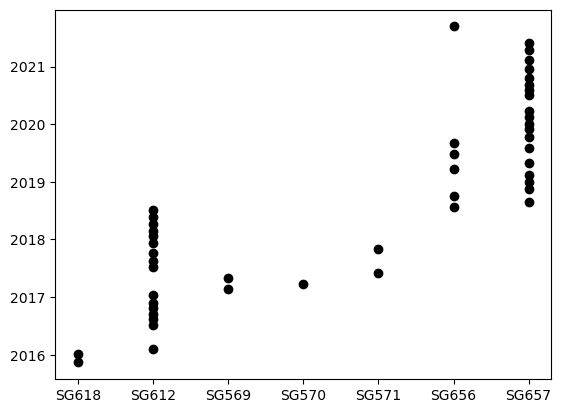

In [385]:
plt.figure()
for i in df_campanha.iterrows():
    plt.plot(i[1]['N/S'][0],i[1].time[0],'ok')

In [389]:
len(df_campanha)

48

In [397]:
df_campanha.head(1)['filename_mseed'].values[0][0],df_campanha.head(1)['filename_mseed'].values[0][-1]

('pa0001au_001_151112_134841', 'pa0315au_044_151219_173844')

In [398]:
len(df_campanha.head(1)['filename_mseed'].values[0])

7839

In [462]:
def mergulho_start_end_time(k):
    try:
        files_mseed_HD = [i for i in filenames_MSEED if i.split('/')[-1].split('.')[0] in k[1]['filename_mseed']]
        
        tr_start = obspy.read(files_mseed_HD[0],headonly=True)[0]

        tr_end = obspy.read(files_mseed_HD[-1],headonly=True)[0]
        
        filename_mseed_HD = [i.split('/')[-1].split('.')[0] for i in files_mseed_HD]
        df_file = k[1].to_frame()

        df_nettab = df_file.T
        df_nettab['station_nettab'] = k[0]
        df_nettab['date_start_nettab'] = tr_start.stats.starttime.strftime('%Y/%j:%H%M')
        df_nettab['date_end_nettab'] = tr_end.stats.endtime.strftime('%Y/%j:%H%M')
        df_nettab['filename_mseed_HD'] = [filename_mseed_HD]
        df_nettab['start_lat'] = k[1]['lat'][0]
        df_nettab['end_lat'] = k[1]['lat'][-1]
        df_nettab['start_lon'] = k[1]['lon'][0]
        df_nettab['end_lon'] = k[1]['lon'][-1]
        df_nettab['N/S'] = k[1]['N/S'][0]
        df_nettab['Fs'] = k[1]['Fs'][0]
        df_nettab['nBits'] = k[1]['nBits'][0]
        df_nettab['Hidrofone'] = k[1]['Hidrofone'][0]
        df_nettab['PreAmp'] = k[1]['PreAmp'][0]
        df_nettab['Ciclo'] = k[1]['Ciclo'][0]

        return df_nettab
    
    except:
        pass

In [463]:
end_time = []
with Pool(processes=4) as p:
    with tqdm(total=len(df_campanha)) as pbar:
        for result in p.imap(mergulho_start_end_time,df_campanha.iterrows()):
            pbar.update()
            end_time.append(result)

100%|███████████████████████████████████████████| 48/48 [00:53<00:00,  1.11s/it]


In [464]:
dataframe_campanha_mseed_final = pd.concat(end_time, ignore_index=True)

In [465]:
dataframe_campanha_mseed_final.head(1).sort_values(by='Ciclo')

time  \
0  [2015-11-12 13:48:40.999995, 2015-11-12 13:50:...   

                                      filename_mseed  \
0  [pa0001au_001_151112_134841, pa0001au_002_1511...   

                                            mergulho  \
0  [0001, 0001, 0001, 0001, 0002, 0002, 0002, 000...   

                                                date  \
0  [2015-11-12, 2015-11-12, 2015-11-12, 2015-11-1...   

                                                 lat  \
0  [-23.825053500000003, -23.8246425, -23.8242279...   

                                                 lon  \
0  [-42.495485, -42.4954925, -42.495501000000004,...   

                                                 dep date_start_nettab    N/S  \
0  [4.36492065, 20.073999999999998, 37.1260000000...     2015/316:1348  SG618   

       Fs  ...  Hidrofone PreAmp Ciclo  station_nettab date_end_nettab  \
0  125000  ...     911006   1501     1           G1500   2015/353:1740   

                                   filename_mseed_HD  start_lat    end_lat  \
0  [pa0001au_001_151112_134841, pa0001au_002_1511... -23.825054 -25.079344   

   start_lon   end_lon  
0 -42.495485 -42.27264  

[1 rows x 21 columns]

In [534]:
lines_nettab = []
for i in dataframe_campanha_mseed_final.iterrows():
    # Station lines (one line per station/sensor/epoch) # code description datalogger%sn seismometer%sn # sampling orientation lat. lon. elev. depth. start end
    #Sl: UNAP "Uni-Iquique/Chile"   DM24%A1383 CMG-3ESP/60%T34622 100 ZNE -20.24393 -70.14041 0.0    0.0 2009/134 
    lines_nettab.append('Sl: '+str(i[1]['station_nettab'])+' C'+str(i[1]['Ciclo']).zfill(2)+':'+i[1]['N/S']+' '+str(i[1]['PreAmp'])+' '+str(i[1]['Hidrofone'])+' 100 H '+str(i[1]['start_lat'])[:8]+' '+str(i[1]['start_lon'])[:8]+' 0 0 '+i[1]['date_start_nettab']+' '+i[1]['date_end_nettab'])
    print('Sl: '+str(i[1]['station_nettab'])+' C'+str(i[1]['Ciclo']).zfill(2)+':'+i[1]['N/S']+' '+str(i[1]['PreAmp'])+' '+str(i[1]['Hidrofone'])+' 100 H '+str(i[1]['start_lat'])[:8]+' '+str(i[1]['start_lon'])[:8]+' 0 0 '+i[1]['date_start_nettab']+' '+i[1]['date_end_nettab'])

Sl: G1500 C01:SG618 1501 911006 100 H -23.8250 -42.4954 0 0 2015/316:1348 2015/353:1740
Sl: G1601 C02:SG618 1501 911006 100 H -23.8396 -42.5041 0 0 2016/008:1014 2016/033:0617
Sl: G1602 C03:SG612 1503 911008 100 H -24.3285 -42.3237 0 0 2016/034:0000 2016/109:0802
Sl: G1604 C05:SG612 1503 911008 100 H -24.3912 -43.8217 0 0 2016/190:1720 2016/229:0640
Sl: G1605 C06:SG612 1503 911008 100 H -24.8122 -43.1406 0 0 2016/230:0745 2016/260:2358
Sl: G1606 C07:SG612 1503 911008 100 H -24.3614 -43.1426 0 0 2016/260:2359 2016/289:0643
Sl: G1607 C08:SG612 1503 911008 100 H -24.6691 -42.8865 0 0 2016/295:0907 2016/325:2044
Sl: G1608 C09:SG612 1503 911008 100 H -25.7623 -44.4332 0 0 2016/326:0411 2017/011:1824
Sl: G1709 C10:SG612 1503 911008 100 H -26.0114 -44.2506 0 0 2017/012:1454 2017/047:0455
Sl: G170A C11:SG569 1502 911005 100 H -24.1170 -41.4956 0 0 2017/048:1101 2017/083:1056
Sl: G170B C12:SG570 1601 911009 100 H -24.5373 -43.2127 0 0 2017/084:2027 2017/120:2329
Sl: G170C C13:SG569 1503 911008 

# Plotando o dataframe com os mergulhos: 

/home/sysop/Programs/miniconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


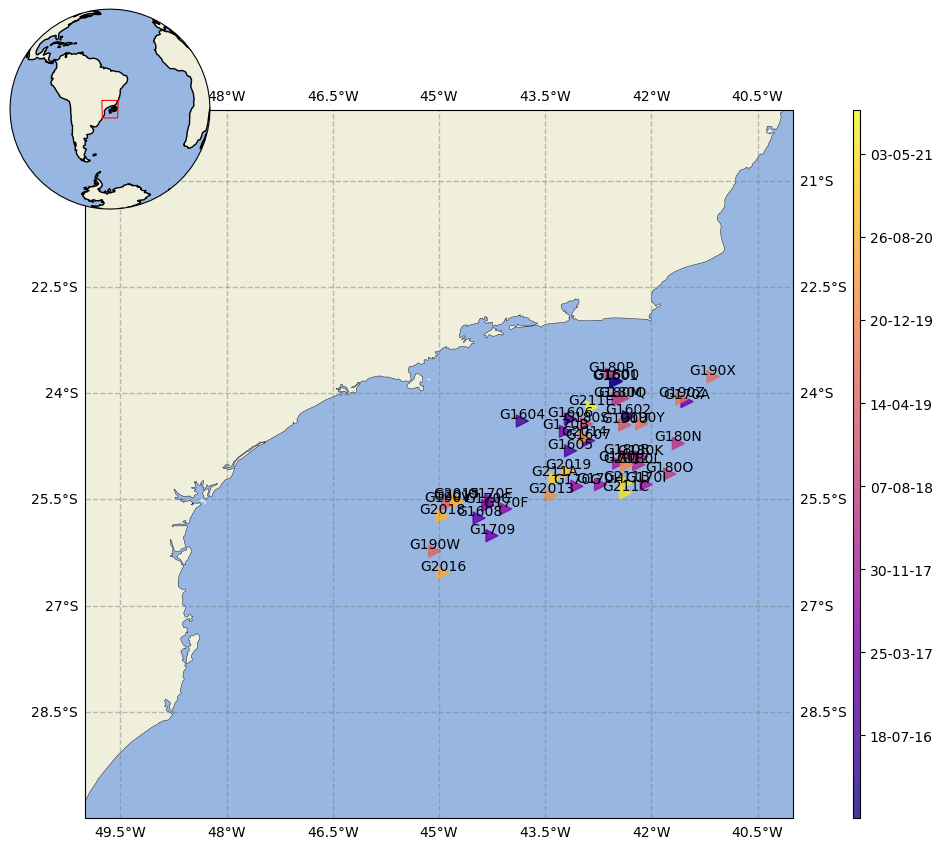

In [535]:

#########################################################################################################################################################
#Figure 

# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1, projection=proj)
                    
# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=proj)

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values
                
h = ax.scatter(dataframe_campanha_mseed_final['start_lon'].values,dataframe_campanha_mseed_final['start_lat'].values,c=np.array([mdates.date2num(UTCDateTime(dataframe_campanha_mseed_final['time'].values[i][0]).date) for i in range(len(dataframe_campanha_mseed_final))]),marker='>',alpha=0.8,cmap='plasma',s=75,transform=proj)
for i in dataframe_campanha_mseed_final.iterrows():
    ax.text(i[1]['start_lon'],i[1]['start_lat'],i[1]['station_nettab'],color="k", fontsize=10,horizontalalignment="center", verticalalignment="bottom",transform=ccrs.Geodetic()) ## Important
# ----------------------------------------------------------------------------------------------------------
# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
   
# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0.05
inset_y = 0.75
inset_size = 0.2

# Adding Geoaxes
ax2 = plt.axes([inset_x, inset_y, inset_size, inset_size], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()
ax2.scatter(dataframe_campanha_mseed_final['start_lon'].values,dataframe_campanha_mseed_final['start_lat'].values,c='k',marker='>',alpha=0.8,s=2,transform=proj)

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
    
lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)

        
# ----------------------------------------------------------------------------------------------------------
# Saving figure
#os.makedirs(FOLDER_OUTPUT+'FIGURAS/INTERP_MSEED/'+st[0].stats.starttime.strftime('%Y')+'/'+st[0].stats.starttime.strftime('%Y-%m-%d')+'/',exist_ok=True)
#fig.savefig(FOLDER_OUTPUT+'FIGURAS/INTERP_MSEED/'+st[0].stats.starttime.strftime('%Y')+'/'+st[0].stats.starttime.strftime('%Y-%m-%d')+'/'+'interp_mseed_'+file_n_meta+'.png')
#plt.close()

# Salvando o arquivo de NETTAB e o DATAFRAME:

In [536]:
with open('/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/df_mergulho_nettab.txt', 'w') as f:
    for line in lines_nettab:
        f.write(line)
        f.write('\n')

In [539]:
df_mergulho_feather.to_feather('/media/sysop/8d2362fc-3b46-49a7-a864-19b2a6ad097b/diogoloc/dados_posdoc/gliders_project/gliders_data/info_csv/df_campanha_glider.feather')

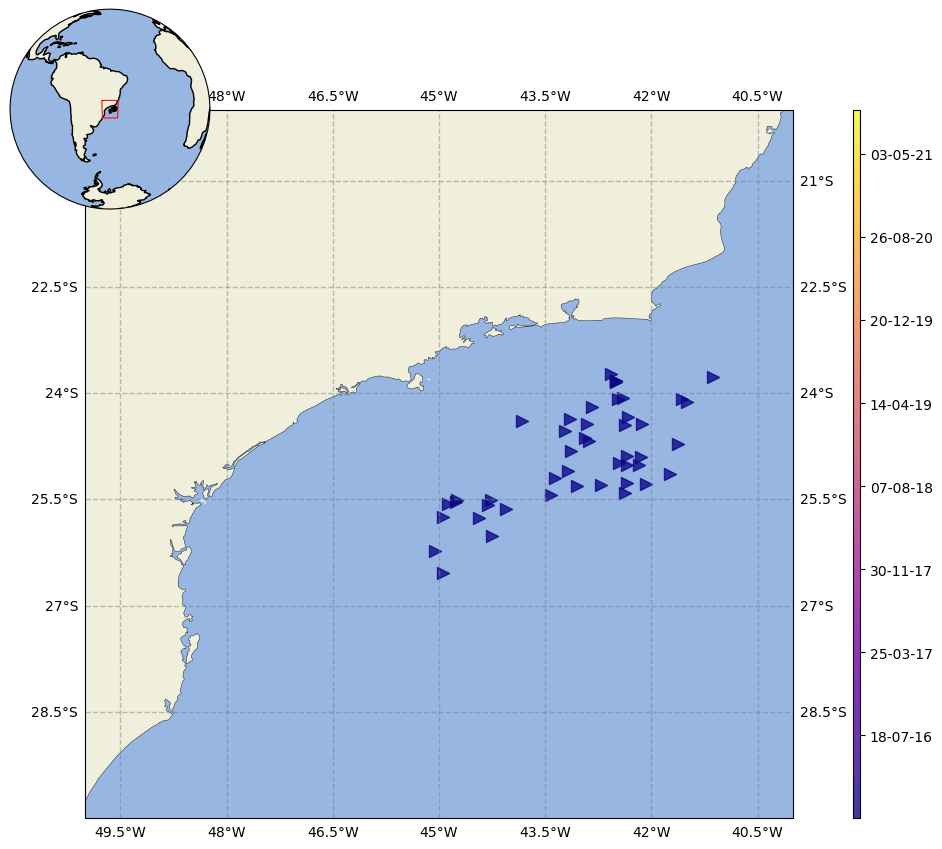

In [596]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

import matplotlib.animation as animation


# set up the plot and create a GeoAxes:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1, projection=proj)
                    
# ----------------------------------------------------------------------------------------------------------
# Limit the extent of the map to a small longitude/latitude range.
latmin=-30
latmax=-20
lonmin=-50
lonmax=-40

ax.set_extent([lonmin,lonmax, latmin, latmax], crs=proj)

# ----------------------------------------------------------------------------------------------------------
# Ploting lat/lon values
# ----------------------------------------------------------------------------------------------------------


# Adding background map 
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE,linewidth=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.3)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
# ----------------------------------------------------------------------------------------------------------
# Adding colorbar
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="1%", pad=0.6, axes_class=plt.Axes)

fig.add_axes(ax_cb)
cb = plt.colorbar(h, cax=ax_cb)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
   
# ----------------------------------------------------------------------------------------------------------
# Adding global location map
# inset location relative to main plot (ax) in normalized units
inset_x = 0.05
inset_y = 0.75
inset_size = 0.2

# Adding Geoaxes
ax2 = plt.axes([inset_x, inset_y, inset_size, inset_size], projection=ccrs.Orthographic(central_latitude=(latmin + latmax)/2,central_longitude=(lonmin + lonmax) / 2))
ax2.set_global()
ax2.scatter(dataframe_campanha_mseed_final['start_lon'].values,dataframe_campanha_mseed_final['start_lat'].values,c='k',marker='>',alpha=0.8,s=2,transform=proj)

# Adding background map 
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)

# Adding red rectangle position
nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
                                 np.linspace(lonmin, lonmax, nvert),
                                 np.linspace(lonmax, lonmax, nvert)].tolist()
    
lats = np.r_[np.linspace(latmin, latmax, nvert),
                                 np.linspace(latmax, latmax, nvert),
                                 np.linspace(latmax, latmin, nvert)].tolist()

ring = LinearRing(list(zip(lons, lats)))
ax2.add_geometries([ring], ccrs.PlateCarree(),facecolor='none', edgecolor='red', linewidth=0.75)                

# ---------
# Animation 
# ---------

x = dataframe_campanha_mseed_final['start_lon'].values
y = dataframe_campanha_mseed_final['start_lat'].values
color = itertools.cycle(np.array([mdates.date2num(UTCDateTime(dataframe_campanha_mseed_final['time'].values[i][0]).date) for i in range(len(dataframe_campanha_mseed_final))]))

def update(i):
    # replot things
    ax.scatter(x[i],y[i],s=75,c=next(color),marker='>',cmap='plasma',alpha=0.8,transform=proj)

ani = animation.FuncAnimation(fig, update,repeat=True, frames=len(x), interval=len(x))

# To save the animation using Pillow as a gif
# writer = animation.PillowWriter(fps=15,
#                                 metadata=dict(artist='Me'),
#                                 bitrate=1800)
# ani.save('scatter.gif', writer=writer)

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='jshtml')
rc

HTML(ani.to_jshtml())